Saved:
  train.csv: data\test_9\train.csv
  test.csv : data\test_9\test.csv
train shape: (50000, 7) test shape: (170000, 7)
test y_type counts:
 y_type
0    110000
1     20000
2     20000
3     20000
Name: count, dtype: int64


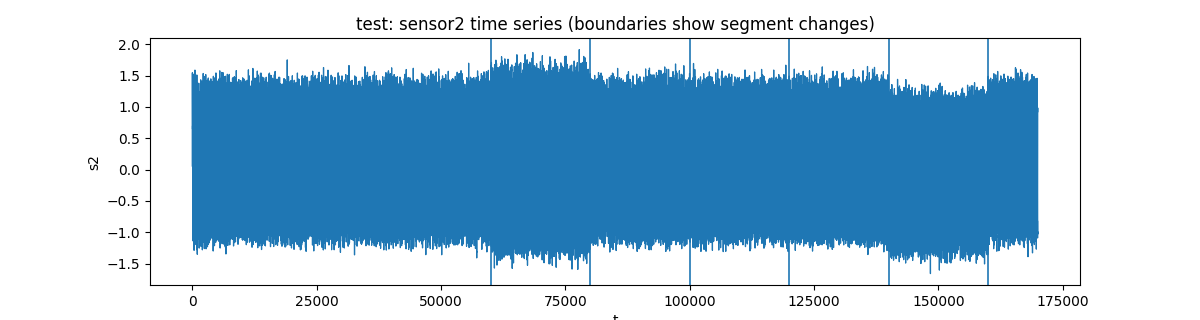

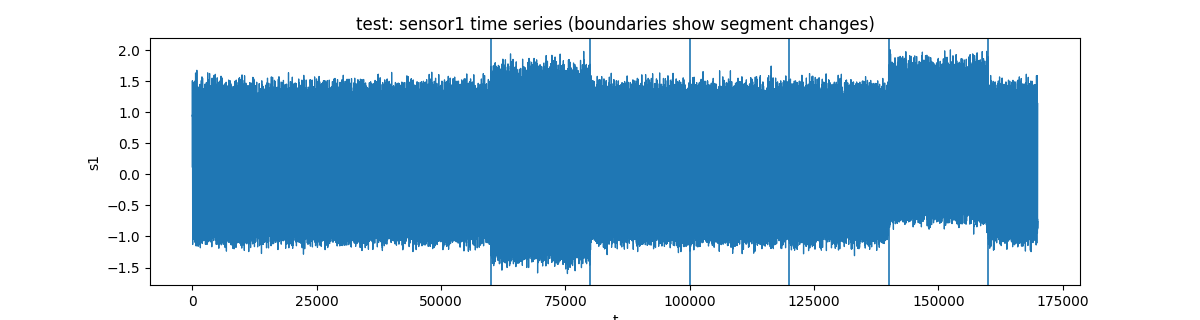

In [2]:
%matplotlib widget

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ============================================================
# 連続時系列版：MMD用 合成データ生成（2センサ）
# ・基本波形テンプレートを固定（「基本波形をもとに」）
# ・異常は区間(test_plan)でのみ発生、異常区間の間は正常
# ・保存はCSVのみ
# ============================================================

# ----------------------------
# 0) 波形の部品
# ----------------------------
def _sawtooth(theta):
    """ノコギリ波（[-1,1]、周期 2π）"""
    x = theta / (2 * np.pi)
    return 2 * (x - np.floor(x + 0.5))

def _gauss_bump(theta, mu, sigma):
    """周期境界をまたいでも自然につながる局所イベント（ガウス山）"""
    d = np.angle(np.exp(1j * (theta - mu)))  # 円周上の距離（-pi,pi]
    return np.exp(-0.5 * (d / sigma) ** 2)

def make_base_cycle_fn(rng, base_complexity=1.0):
    """
    「基本波形」を固定するためのテンプレート関数を生成。
    1サイクルの形状パラメータをここで一度だけ乱数で決める。
    """
    phi1 = rng.uniform(-0.2, 0.2)
    phi2 = rng.uniform(-0.2, 0.2)
    phi3 = rng.uniform(-0.2, 0.2)

    a1 = rng.uniform(0.8, 1.2) * base_complexity
    a2 = rng.uniform(0.15, 0.35) * base_complexity
    a3 = rng.uniform(0.05, 0.20) * base_complexity
    b  = rng.uniform(0.05, 0.25) * base_complexity
    saw_shift = rng.uniform(-0.1, 0.1)

    mu1  = rng.uniform(0.2 * np.pi, 1.8 * np.pi)
    sig1 = rng.uniform(0.06 * np.pi, 0.14 * np.pi)
    g1   = rng.uniform(0.15, 0.50) * base_complexity

    mu2  = rng.uniform(0.2 * np.pi, 1.8 * np.pi)
    sig2 = rng.uniform(0.05 * np.pi, 0.12 * np.pi)
    g2   = rng.uniform(0.00, 0.35) * base_complexity

    dc = rng.uniform(-0.2, 0.2) * base_complexity

    def f(theta):
        y = (
            a1 * np.sin(theta + phi1)
            + a2 * np.sin(2 * theta + phi2)
            + a3 * np.sin(3 * theta + phi3)
            + b  * _sawtooth(theta + saw_shift)
            + g1 * _gauss_bump(theta, mu1, sig1)
            + g2 * _gauss_bump(theta, mu2, sig2)
        )
        return y + dc

    return f

# ----------------------------
# 1) 1サイクル（ノイズ無し）を2センサで生成（テンプレート固定）
# ----------------------------
def make_clean_cycle_two_sensors(
    L,
    rng,
    base1_fn,
    base2_fn,
    coupling_base,
    mode=0,
    severity=None,
    normal_jitter=0.02,
    base_complexity=1.0
):
    """
    mode:
      0=正常
      1=異常①（高周波成分を追加）
      2=異常②（位相ズレ）
      3=異常③（波形全体がシフト：オフセット）
    """
    if severity is None:
        severity = {}

    theta = np.linspace(0, 2 * np.pi, L, endpoint=False)

    # 正常のばらつき（位相揺らぎ + 軽い時間ゆがみ）
    shift = rng.normal(0.0, normal_jitter)
    warp_amp = rng.uniform(0.0, 0.03) * base_complexity
    warp_phi = rng.uniform(0, 2 * np.pi)
    theta_n = theta + shift + warp_amp * np.sin(theta + warp_phi)

    # 位相ズレ（mode=2）は、theta_n 全体をずらす
    if mode == 2:
        phase_shift = severity.get("phase_shift", 0.35)  # rad
        theta_use = theta_n + phase_shift
    else:
        theta_use = theta_n

    # 基本波形（テンプレート）から2センサ生成
    s1 = base1_fn(theta_use)

    s2_phase = rng.uniform(-0.08, 0.08)
    s2 = 0.75 * base2_fn(theta_use + s2_phase)

    # センサ間の相関（結合）
    # coupling_base を中心に、毎サイクル少しだけ揺らす（完全固定が良ければ 0.0 に）
    coupling_jitter = severity.get("coupling_jitter", 0.03)
    coupling = np.clip(coupling_base + rng.normal(0.0, coupling_jitter), 0.0, 1.2)
    s2 = s2 + coupling * (s1 - np.mean(s1))

    # 異常①：高周波成分を追加（mode=1）
    if mode == 1:
        hf_k = int(severity.get("hf_k", 10))                 # 周波数（整数が分かりやすい）
        hf_amp = severity.get("hf_amp", 0.35)                # 追加成分の振幅
        hf_s2_ratio = severity.get("hf_s2_ratio", 0.8)       # s2への入り方
        hf_phi = rng.uniform(0, 2*np.pi)

        hf = np.sin(hf_k * theta_use + hf_phi)
        s1 = s1 + hf_amp * hf
        s2 = s2 + (hf_amp * hf_s2_ratio) * np.sin(hf_k * theta_use + hf_phi + rng.uniform(-0.2, 0.2))

    # 異常③：波形全体がシフト（オフセット）（mode=3）
    if mode == 3:
        dc1 = severity.get("dc_shift_s1", 0.35)
        dc2 = severity.get("dc_shift_s2", -0.20)
        s1 = s1 + dc1
        s2 = s2 + dc2

    return s1.astype(np.float32), s2.astype(np.float32)

# ----------------------------
# 2) 連結後にノイズを加える（要求どおり）
# ----------------------------
def _ar1_noise(N, rng, sigma=0.05, rho=0.85):
    """AR(1)色付きノイズ"""
    e = rng.normal(0.0, sigma, size=N)
    y = np.empty(N, dtype=float)
    y[0] = e[0]
    for i in range(1, N):
        y[i] = rho * y[i - 1] + e[i]
    return y

def add_noise_after_concat(s, rng, sigma=0.05, rho=0.85):
    """連結後の時系列全体に色付きノイズを足す"""
    return (s.astype(float) + _ar1_noise(len(s), rng, sigma=sigma, rho=rho)).astype(np.float32)

# ----------------------------
# 3) 連続時系列データセット生成（CSV保存は train/test のみ）
# ----------------------------
def build_dataset_time_series_csv_only(
    L=128,
    N_train=50000,
    test_plan=None,   # 例: [(60000,0),(50000,1),(10000,0),(30000,2),(...)]
    seed=42,
    severity=None,
    base_complexity=1.0,
    normal_jitter=0.02,
    noise_sigma_s1=0.05,
    noise_sigma_s2=0.05,
    noise_rho_s1=0.85,
    noise_rho_s2=0.85,
    out_dir="./data/test_8"
):
    if test_plan is None:
        raise ValueError("test_plan を指定してください（異常の間を正常にしたいので、区間列で与えるのが確実です）。")

    N_test = int(sum(seg_len for seg_len, _ in test_plan))

    rng = np.random.default_rng(seed)
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # ---- 基本波形テンプレートを固定（train/test で共通）
    base1_fn = make_base_cycle_fn(rng, base_complexity=base_complexity)
    base2_fn = make_base_cycle_fn(rng, base_complexity=base_complexity)
    coupling_base = rng.uniform(0.10, 0.35)

    # ---- train（正常のみ）: サイクル生成→連結（ノイズ無し）
    train_s1_clean, train_s2_clean = [], []
    remaining = N_train
    while remaining > 0:
        c1, c2 = make_clean_cycle_two_sensors(
            L, rng, base1_fn, base2_fn, coupling_base,
            mode=0, severity=severity, normal_jitter=normal_jitter, base_complexity=base_complexity
        )
        take = min(L, remaining)
        train_s1_clean.append(c1[:take])
        train_s2_clean.append(c2[:take])
        remaining -= take

    train_s1_clean = np.concatenate(train_s1_clean)
    train_s2_clean = np.concatenate(train_s2_clean)

    # 連結後にノイズ
    train_s1 = add_noise_after_concat(train_s1_clean, rng, sigma=noise_sigma_s1, rho=noise_rho_s1)
    train_s2 = add_noise_after_concat(train_s2_clean, rng, sigma=noise_sigma_s2, rho=noise_rho_s2)

    df_train = pd.DataFrame({
        "t": np.arange(N_train, dtype=np.int32),
        "s1": train_s1,
        "s2": train_s2,
        "y": np.zeros(N_train, dtype=np.int16),
        "y_type": np.zeros(N_train, dtype=np.int16),
        "segment": np.zeros(N_train, dtype=np.int16),
        "split": "train",
    })

    # ---- test: 区間ごとに mode を切り替えて「ノイズ無しで連結」
    test_s1_clean, test_s2_clean = [], []
    y_type = np.empty(N_test, dtype=np.int16)
    segment = np.empty(N_test, dtype=np.int16)

    idx = 0
    for seg_id, (seg_len, mode) in enumerate(test_plan):
        remaining = int(seg_len)
        while remaining > 0:
            c1, c2 = make_clean_cycle_two_sensors(
                L, rng, base1_fn, base2_fn, coupling_base,
                mode=mode, severity=severity, normal_jitter=normal_jitter, base_complexity=base_complexity
            )
            take = min(L, remaining)
            test_s1_clean.append(c1[:take])
            test_s2_clean.append(c2[:take])
            y_type[idx:idx+take] = int(mode)
            segment[idx:idx+take] = int(seg_id)
            idx += take
            remaining -= take

    test_s1_clean = np.concatenate(test_s1_clean)
    test_s2_clean = np.concatenate(test_s2_clean)

    # 連結後にノイズ
    test_s1 = add_noise_after_concat(test_s1_clean, rng, sigma=noise_sigma_s1, rho=noise_rho_s1)
    test_s2 = add_noise_after_concat(test_s2_clean, rng, sigma=noise_sigma_s2, rho=noise_rho_s2)

    y = (y_type != 0).astype(np.int16)

    df_test = pd.DataFrame({
        "t": np.arange(N_test, dtype=np.int32),
        "s1": test_s1,
        "s2": test_s2,
        "y": y,
        "y_type": y_type,
        "segment": segment,
        "split": "test",
    })

    # ---- CSV保存
    train_csv = out_path / "train.csv"
    test_csv  = out_path / "test.csv"
    df_train.to_csv(train_csv, index=False, float_format="%.6g")
    df_test.to_csv(test_csv, index=False, float_format="%.6g")

    return df_train, df_test, train_csv, test_csv

# ============================================================
# 4) 調整パラメータ（異常の形）
# ============================================================
SEVERITY = {
    # 異常①（高周波追加）
    "hf_k": 10,             # 高周波の周波数（大きいほど細かい振動が増える）
    "hf_amp": 0.35,         # 追加成分の大きさ
    "hf_s2_ratio": 0.8,     # s2側の入り方（0ならs2は無関係）

    # 異常②（位相ズレ）
    "phase_shift": 0.35,    # rad

    # 異常③（全体シフト：オフセット）
    "dc_shift_s1": 0.35,
    "dc_shift_s2": -0.20,

    # センサ結合の揺らぎ（0にすると結合がほぼ固定）
    "coupling_jitter": 0.03,
}

# ============================================================
# 5) 実行（生成 + CSV保存）
#    「異常の間は正常データ」なので、必ず normal(0) を挟む
# ============================================================
# 例：normal → 異常① → normal → 異常② → normal → 異常③ → normal
test_plan = [
    (60000, 0),
    (20000, 1),
    (20000, 0),
    (20000, 2),
    (20000, 0),
    (20000, 3),
    (10000, 0),
]  # 合計 150000

df_train, df_test, train_csv, test_csv = build_dataset_time_series_csv_only(
    L=128,
    N_train=50000,
    test_plan=test_plan,
    seed=42,
    severity=SEVERITY,
    base_complexity=1.0,
    normal_jitter=0.02,
    noise_sigma_s1=0.05,
    noise_sigma_s2=0.05,
    noise_rho_s1=0.85,
    noise_rho_s2=0.85,
    out_dir="./data/test_9"
)

print("Saved:")
print("  train.csv:", train_csv)
print("  test.csv :", test_csv)
print("train shape:", df_train.shape, "test shape:", df_test.shape)
print("test y_type counts:\n", df_test["y_type"].value_counts().sort_index())

# ============================================================
# 6) 可視化（区間境界を自動で描く）
# ============================================================
boundaries = np.cumsum([seg_len for seg_len, _ in test_plan])[:-1]

fig = plt.figure(figsize=(12, 3.2))
ax = fig.add_subplot(1,1,1)
ax.plot(df_test["t"].values, df_test["s1"].values, linewidth=0.9)
for b in boundaries:
    ax.axvline(b, linewidth=1.2)
ax.set_title("test: sensor1 time series (boundaries show segment changes)")
ax.set_xlabel("t")
ax.set_ylabel("s1")

fig2 = plt.figure(figsize=(12, 3.2))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(df_test["t"].values, df_test["s2"].values, linewidth=0.9)
for b in boundaries:
    ax2.axvline(b, linewidth=1.2)
ax2.set_title("test: sensor2 time series (boundaries show segment changes)")
ax2.set_xlabel("t")
ax2.set_ylabel("s2")

plt.show()
